In [10]:
from torchvision.datasets import CIFAR100
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import tqdm
import os
from IPython.display import clear_output
import numpy as np

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import torchvision.models as models
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt

In [11]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Интерполяция

### функции и скачивание датасета

In [12]:
#!g1.1
from tqdm.notebook import tqdm
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),

    
]) 

test_set = CIFAR100(root='./data', transform=transform, train=False, download=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified


In [13]:
#!g1.1
def make_inter_layer(alpha, first, second, ans_layer):
  with torch.no_grad():
      if "weight" in first.state_dict():
        ans_layer.weight.copy_(alpha * first.weight)
      if "weight_orig" in first.state_dict():
        ans_layer.weight.copy_(alpha * (first.weight_orig * first.weight_mask))
    
      if "weight" in second.state_dict():
        ans_layer.weight += (1. - alpha) * second.weight
      if "weight_orig" in second.state_dict():
        ans_layer.weight += (1. - alpha) * (second.weight_orig * second.weight_mask)

      if "bias" in ans_layer.state_dict():
        ans_layer.bias.copy_(alpha * first.bias + (1. - alpha) * second.bias)

def interpolation(alpha: float, first: models.resnet18, second: models.resnet18) ->  models.resnet18:
  kwargs = dict(
      num_classes=100,
  )

  ans = models.resnet18(**kwargs).to(device)

  zipped = zip(first.modules(), second.modules(), ans.modules())

  for layer_first, layer_second, layer_ans in zipped:
    if "weight" in layer_ans.state_dict() and not "running_mean" in layer_ans.state_dict(): # чтобы не копировать веса батчнорм
      make_inter_layer(alpha, layer_first, layer_second, layer_ans)

  ans.train()
  loss_inst = nn.CrossEntropyLoss()
  for X_batch, y_batch in tqdm(test_loader, desc='testing'):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
      logits = ans(X_batch)
      loss = loss_inst(logits, y_batch)
  
  return ans

def loss_calculation(net):
    loss_inst = nn.CrossEntropyLoss()
    test_loss, test_accuracy = 0.0, 0.0
    net.eval()
    for X_batch, y_batch in tqdm(test_loader, desc='testing'):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      with torch.no_grad():
        logits = net(X_batch)
        loss = loss_inst(logits, y_batch)
      
      test_loss += loss.item() * X_batch.shape[0]
      test_accuracy += (logits.argmax(dim=1) == y_batch).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

def get_losses(ndots, first, second):
  x = np.linspace(0, 1, ndots)
  res = []
  for i, num in enumerate(x):
    with torch.no_grad():
      inter = interpolation(num, first, second).to(device)
    print(i)
    res.append((num, loss_calculation(inter)[0]))
    clear_output()
  return res

def get_losses_and_accuracies(ndots, first, second):
  x = np.linspace(0, 1, ndots)
  res = []
  for i, num in enumerate(x):
    with torch.no_grad():
      inter = interpolation(num, first, second).to(device)
    print(i)
    loss, accuracy = loss_calculation(inter)
    res.append((num, loss, accuracy))
    clear_output()
  return res

def plot_losses(num_of_graphs, los_for_plot):
  fig, axs = plt.subplots(1, num_of_graphs, figsize=(30, 5))
  
  for i in range(num_of_graphs):
    x = [p for p, j in los_for_plot[i]]
    y = [j for p, j in los_for_plot[i]]
    axs[i].plot(x, y, color="red", label="line")
    if (i + 1 == num_of_graphs):
      axs[i].set(title="pruned")
    else:
      axs[i].set(title="prune_it" + str(i))
  plt.show()

def plot_losses_and_accuracies(num_of_graphs, loss_and_accuracy_for_plot):
  fig, axs = plt.subplots(2, num_of_graphs, figsize=(30, 10))
  
  for i in range(num_of_graphs):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [j for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[0][i].plot(x, y, color="red", label="line")
    axs[0][i].set(title="prune_it" + str(i))
  axs[0][0].set_ylabel("loss", size=20)

  for i in range(num_of_graphs):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [k for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[1][i].plot(x, y, color="red", label="line")

  axs[1][0].set_ylabel("accuracy", size=20)

  plt.show()

### Сравнение моделей обрезанных окончательно с промежуточными результатами, ***добавил графики accuracy***

#### pr0.99_sched0_lr0.03

In [14]:
#!g1.1
pruned = torch.load("models/pr0.99_sched0_lr0.03_iters10001/pruned").to(device)
directory = "models/pr0.99_sched0_lr0.03_iters10001"
loss_and_accuracy_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, pruned, model))

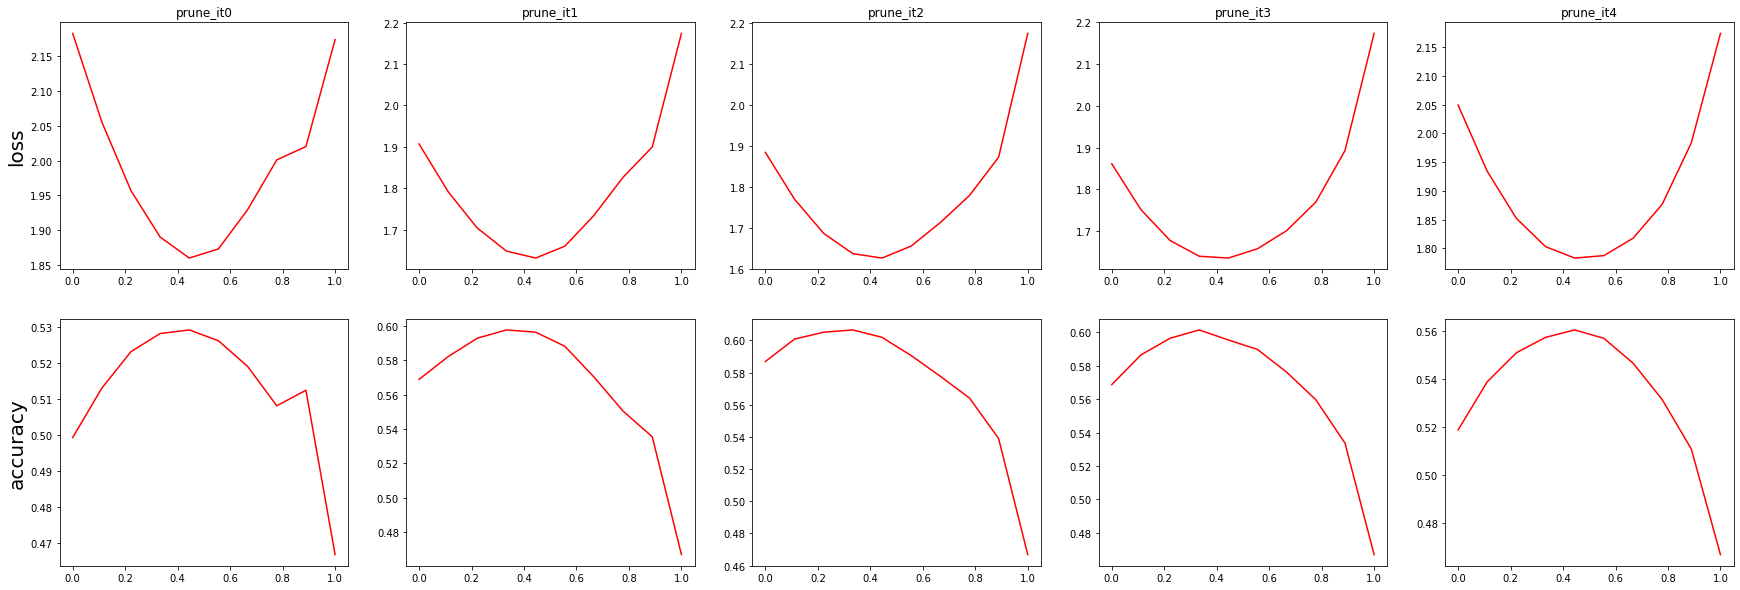

In [15]:
#!g1.1
plot_losses_and_accuracies(5, loss_and_accuracy_for_plot)
#    prune_it0                          pruned  prune_it1                          pruned   prune_it2                            pruned  pruneit3                             pruned  prune_it4                           pruned

#### pr0.99_sched1_lr0.03

In [18]:
#!g1.1
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10001/pruned").to(device)
directory = "models/pr0.99_sched0_lr0.03_iters10001"
loss_and_accuracy_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, pruned, model))

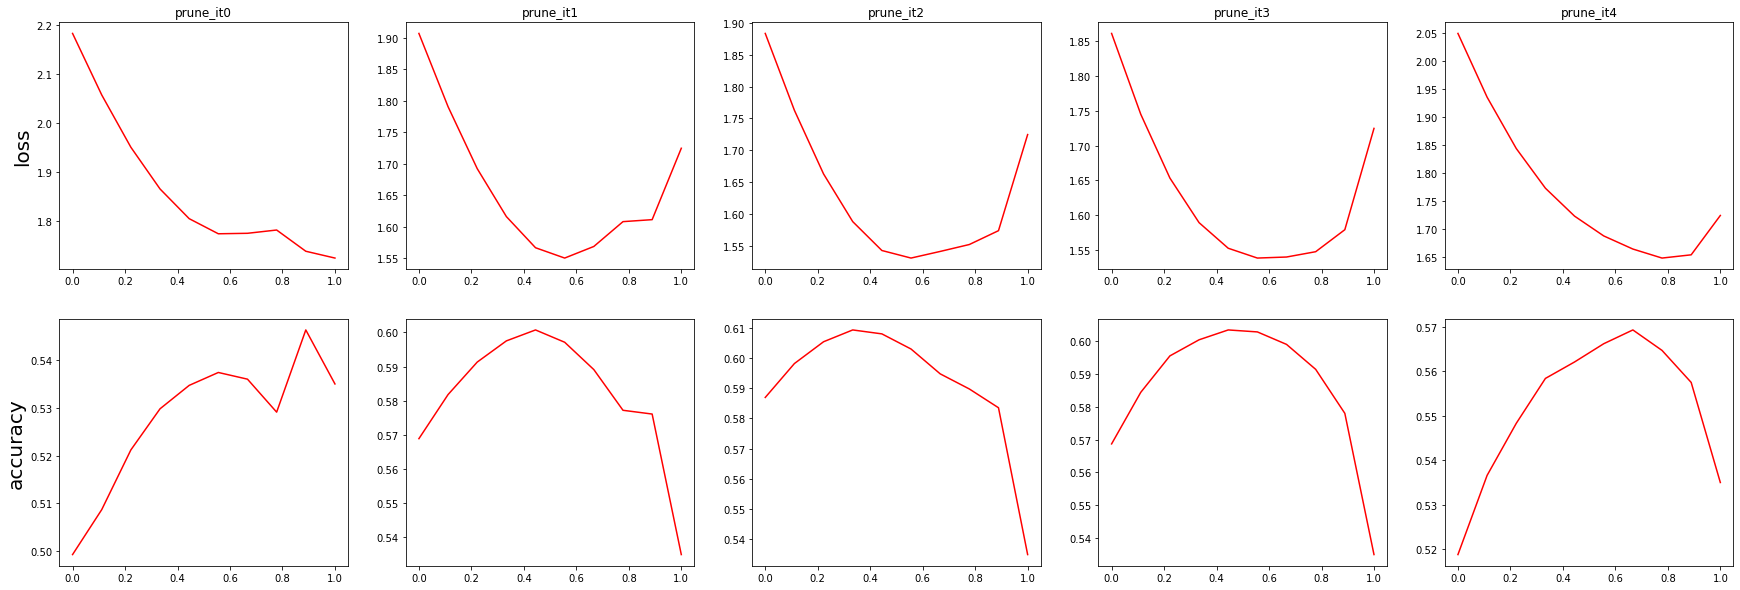

In [19]:
#!g1.1
plot_losses_and_accuracies(5, loss_and_accuracy_for_plot)
#    prune_it0                          pruned  prune_it1                          pruned   prune_it2                            pruned  pruneit3                             pruned  prune_it4                           pruned

#### pr0.99_sched0_lr0.03_pruned vs pr0_sched0_lr0.03

In [16]:
#!g1.1
base = torch.load("models/pr0_sched0_lr0.03_iters10000/pruned")
pruned = torch.load("models/pr0.99_sched0_lr0.03_iters10001/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, pruned, base)

[Text(0.5, 1.0, 'accuracy')]

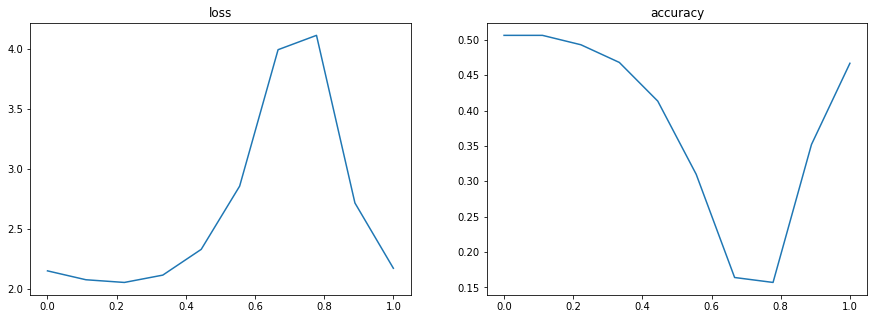

In [17]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


#### pr0.99_sched1_lr0.03_pruned vs pr0_sched0_lr0.03

In [20]:
#!g1.1
base = torch.load("models/pr0_sched0_lr0.03_iters10000/pruned")
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10001/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, pruned, base)

[Text(0.5, 1.0, 'accuracy')]

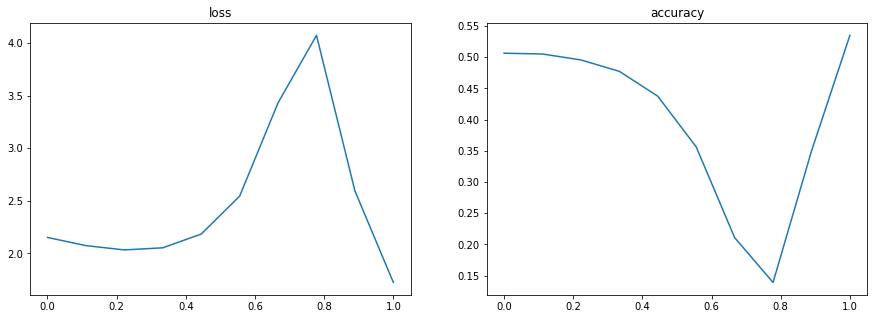

In [21]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


#### pr0.99_sched0_lr0.03_pruned vs pr0.99_sched1_lr0.03_pruned

In [22]:
#!g1.1
base = torch.load("models/pr0.99_sched0_lr0.03_iters10001/pruned")
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10001/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, pruned, base)

[Text(0.5, 1.0, 'accuracy')]

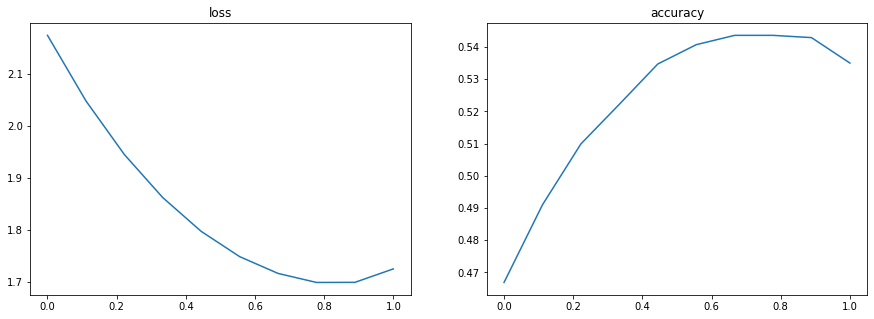

In [23]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


Решил сравнить обрезанную на 99% и на 95%

In [24]:
#!g1.1
base = torch.load("models/pr0.99_sched0_lr0.03_iters10001/pruned")
pruned = torch.load("models/pr0.95_sched0_lr0.03_iters10000/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, pruned, base)

[Text(0.5, 1.0, 'accuracy')]

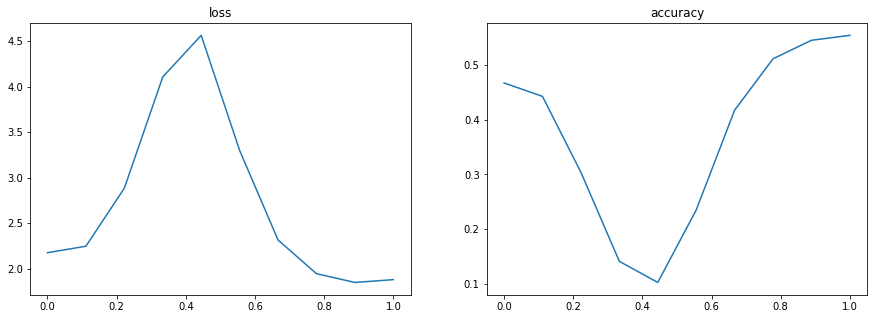

In [25]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


### Сравнение последовательных шагов

#### Для модели без шедулера


#### pr0.99_sched0_lr0.03

In [ ]:
#!g1.1
pruned = torch.load("models/pr0.99_sched0_lr0.03_iters10000/pruned").to(device)
directory = "models/pr0.99_sched0_lr0.03_iters10000"
loss_and_accuracy_for_plot = []
files = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      files.append(f)
for i in range(0, len(files) - 1):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 1]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

In [ ]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                     prune_it=1  prune_it=1                             prune_it=2   prune_it=2                                 prune_it=3   prune_it=3                                    prune_it=4

#### pr0.99_sched1_lr0.03

In [ ]:
#!g1.1
# 1 - 3, 2 - 4, 3 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 2):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 2]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))


In [ ]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                  prune_it=2     prune_it=1                                                   prune_it=3  prune_it=2                                                      prune_it=4

In [ ]:
#!g1.1
# 1 - 4, 2 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 3):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 3]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

In [ ]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                                                     prune_it=3         prune_it=1                                                                                  prune_it=4

In [ ]:
#!g1.1
# это буквально между 1 и 5, просто для красоты цикл оставил
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 4):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 4]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

In [ ]:
#!g1.1
# plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
  
for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [j for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[0].plot(x, y, color="red", label="line")
    axs[0].set(title="prune_it" + str(i))
    axs[0].set_ylabel("loss", size=20)

for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [k for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[1].plot(x, y, color="red", label="line")

axs[1].set_ylabel("accuracy", size=20)

plt.show()
#   prune_it=0                                                          prune_it=4

#### Для модели с шедулером



In [ ]:
#!g1.1
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10000/pruned").to(device)
directory = "models/pr0.99_sched1_lr0.03_iters10000"
loss_and_accuracy_for_plot = []
files = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      files.append(f)
for i in range(0, len(files) - 1):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 1]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

In [ ]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                     prune_it=1  prune_it=1                             prune_it=2   prune_it=2                                 prune_it=3   prune_it=3                                    prune_it=4

#### pr0.99_sched1_lr0.03

In [ ]:
#!g1.1
# 1 - 3, 2 - 4, 3 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 2):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 2]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))


In [ ]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                  prune_it=2     prune_it=1                                                   prune_it=3  prune_it=2                                                      prune_it=4

In [ ]:
#!g1.1
# 1 - 4, 2 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 3):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 3]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

In [ ]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                                                     prune_it=3         prune_it=1                                                                                  prune_it=4

In [ ]:
#!g1.1
# это буквально между 1 и 5, просто для красоты цикл оставил
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 4):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 4]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

In [ ]:
#!g1.1
# plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
  
for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [j for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[0].plot(x, y, color="red", label="line")
    axs[0].set(title="prune_it" + str(i))
    axs[0].set_ylabel("loss", size=20)

for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [k for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[1].plot(x, y, color="red", label="line")

axs[1].set_ylabel("accuracy", size=20)

plt.show()
#   prune_it=0                                                          prune_it=4